In [1]:
!pip -q install transformers pillow matplotlib
!pip -q install timm

import torch, timm
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform
import urllib.request
from transformers import AutoImageProcessor, AutoModelForImageClassification
device = "cuda" if torch.cuda.is_available() else "cpu"

#Part 1

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
vitModel = timm.create_model("vit_tiny_patch16_224", pretrained=True).to(device)
vitModel.eval()
config = resolve_data_config({}, model=vitModel)
transform = create_transform(**config)
url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/coco_sample.png"
img = Image.open(requests.get(url, stream=True).raw).convert("RGB")
x = transform(img).unsqueeze(0).to(device)
with torch.no_grad():
    logits = vitModel(x)
    top1 = logits.argmax(dim=-1).item()
labelsUrl = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
urllib.request.urlretrieve(labelsUrl, "imagenet_classes.txt")
with open("imagenet_classes.txt") as f:
    labels = [line.strip() for line in f.readlines()]
print("Top 1 class name label name is:-", labels[top1])

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

Top 1 class name label name is:- tabby


#Part 2

In [3]:
processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224" )
vitModel = AutoModelForImageClassification.from_pretrained(
    "google/vit-base-patch16-224",
    attn_implementation="eager",
).to(device)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

### Part 2 (a)

In [4]:
url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/coco_sample.png"
img = Image.open(requests.get(url, stream=True).raw).convert("RGB")
inputs = processor(images=img, return_tensors="pt").to(device)
with torch.no_grad():
    inputs = processor(images=img, return_tensors="pt").to(device)
    out = vitModel(**inputs, output_attentions=True, return_dict=True)
pred = out.logits.argmax(dim=-1).item()
attn = out.attentions[-1]
attn = attn[0]
clsToToken = attn[:, 0, 1:]
clsToPatches = clsToToken.mean(dim=0)
totalPatches = clsToPatches.shape[0]
gridSize = int(np.sqrt(totalPatches))
# assert grid_size * grid_size == num_patches, "Num patches not a perfect square?"
attnMap = clsToPatches.reshape(gridSize, gridSize).detach().cpu()
attnMap = (attnMap - attnMap.min()) / (attnMap.max() - attnMap.min() + 1e-8)
w, h = img.size
attnUp = F.interpolate(attnMap.unsqueeze(0).unsqueeze(0), size=(h, w), mode="bilinear", align_corners=False)
attnUp = attnUp.squeeze().numpy()

Top-1: Egyptian cat


### Part 2 (b)

In [7]:
print("number of layers:", len(out.attentions))
lastAtten = out.attentions[-1]
print("last layer shape:", tuple(lastAtten.shape))
B, H, S, S2 = lastAtten.shape
patch = vitModel.config.patch_size
imgSize = vitModel.config.image_size
totalPatchedExpected = (imgSize // patch) * (imgSize // patch)
print("patchSize:", patch, "imageSize:", imgSize)
print("TotalPatches:", totalPatchedExpected)
print("sequence Length S:", S, "S-1:", S - 1) #s-1 should match totalPatches+1
print("Confirming: sequenceLength = TotalPatches + 1 (CLS token is included)")

number of layers: 12
last layer shape: (1, 12, 197, 197)
patchSize: 16 imageSize: 224
TotalPatches: 196
sequence Length S: 197 S-1: 196
Confirming: sequenceLength = TotalPatches + 1 (CLS token is included)


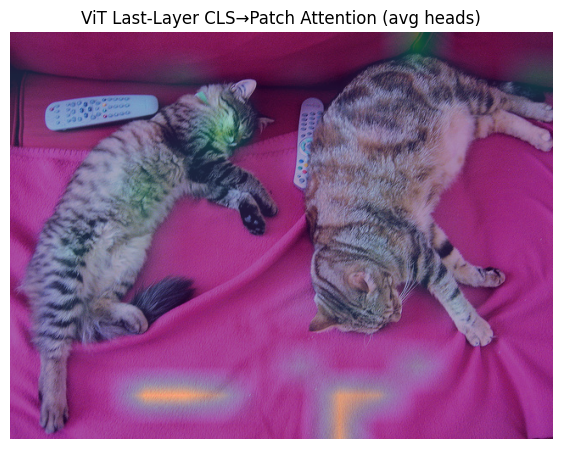

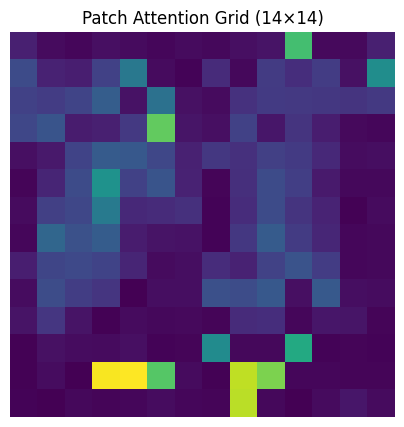

In [8]:
plt.figure(figsize=(7, 7))
plt.imshow(img)
plt.imshow(attnUp, alpha=0.45)
plt.axis("off")
plt.title("ViT Last-Layer CLS→Patch Attention (avg heads)")
plt.show()
plt.figure(figsize=(5, 5))
plt.imshow(attnMap, interpolation="nearest")
plt.axis("off")
plt.title("Patch Attention Grid (14×14)")
plt.show()

### Part 2 (c)

In [9]:
lastAtten.shape
aggregatedAtten = lastAtten.mean(dim=1)
clsAttention = aggregatedAtten[:, 0, :]
clsPatches = clsAttention[:, 1:]
print("End attention vector shape:", clsPatches.shape)

Final attention vector shape: torch.Size([1, 196])


### Part 2 (d)

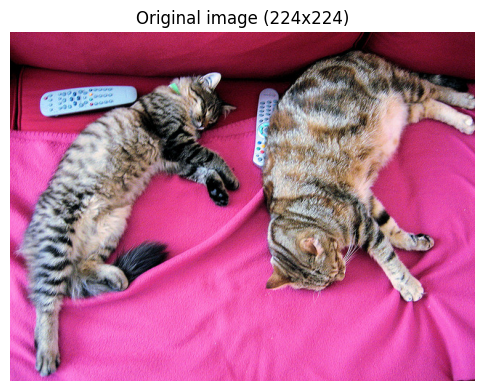

img_np shape: (480, 640, 3) dtype: uint8


In [16]:

img_np = np.array(img.convert("RGB"))

plt.figure(figsize=(6,6))
plt.imshow(img_np)
plt.axis("off")
plt.title("Original image (224x224)")
plt.show()

print("img_np shape:", img_np.shape, "dtype:", img_np.dtype)


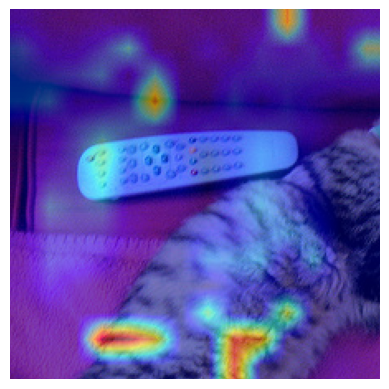

In [28]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import ViTImageProcessor, ViTForImageClassification
from PIL import Image

model_name = 'google/vit-base-patch16-224'
processor = ViTImageProcessor.from_pretrained(model_name)
model = ViTForImageClassification.from_pretrained(model_name, attn_implementation="eager",
)
inputs = processor(images=img, return_tensors="pt").to(device)
image = img
inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs, output_attentions=True, return_dict=True)
attentions = outputs.attentions[-1]
avgAttention = torch.mean(attentions, dim=1)
clsAttention = avgAttention[0, 0, 1:]
grid_size = int(np.sqrt(clsAttention.size(-1)))
mask = clsAttention.reshape(grid_size, grid_size).detach().numpy()
mask = (mask - mask.min()) / (mask.max() - mask.min())
plt.imshow(image)
plt.imshow(mask, cmap='jet', alpha=0.5, extent=(0, 224, 224, 0), interpolation='bilinear')
plt.axis('off')
plt.show()


### Part 3
#### Answerd in Report

### Part 4

In [ ]:

PATCH = 16
GRID = 224 // PATCH
# 14
NUM_PATCHES = GRID * GRID
# 196

id2label = vitModel.config.id2label

@torch.no_grad()
def predictFromPixelValues(pixelValues):
    out = vitModel(pixel_values=pixelValues)
    probs = F.softmax(out.logits, dim=-1)[0]
    predId = probs.argmax().item()
    conf = probs[predId].item()
    return predId, id2label[predId], conf, probs

def maskRandomPatches(pixelValues, ratio, fill=0.0):
    pv = pixelValues.clone()
    k = int(round(ratio * NUM_PATCHES))
    idx = torch.randperm(NUM_PATCHES, device=pv.device)[:k]

    for p in idx:
        r = (p // GRID).item()
        c = (p % GRID).item()
        y0, y1 = r * PATCH, (r + 1) * PATCH
        x0, x1 = c * PATCH, (c + 1) * PATCH
        pv[:, :, y0:y1, x0:x1] = fill
    return pv

def maskCenterBlock(pixelValues, blockPatches, fill=0.0):
    pv = pixelValues.clone()
    start = (GRID - blockPatches) // 2
    end = start + blockPatches

    y0, y1 = start * PATCH, end * PATCH
    x0, x1 = start * PATCH, end * PATCH
    pv[:, :, y0:y1, x0:x1] = fill
    return pv

def showMaskedImage(pixelValues, title):
    mean = torch.tensor(processor.image_mean).view(1, 3, 1, 1).to(pixelValues.device)
    std  = torch.tensor(processor.image_std).view(1, 3, 1, 1).to(pixelValues.device)

    imgVis = (pixelValues * std + mean).clamp(0, 1)
    imgVis = imgVis[0].permute(1, 2, 0).detach().cpu().numpy()

    plt.figure(figsize=(5,5))
    plt.imshow(imgVis)
    plt.axis("off")
    plt.title(title)
    plt.show()


BASELINE: Egyptian cat  conf=0.9374


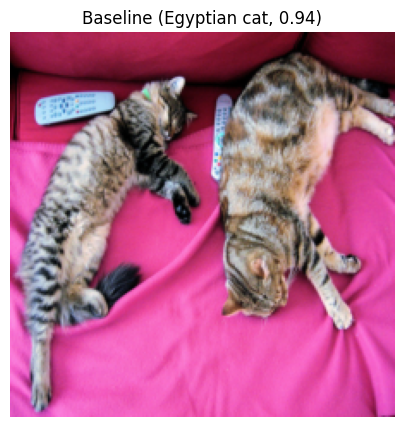


RANDOM MASKING (repeat because random)
ratio=0.1  most_common=Egyptian cat               avg_conf=0.8366  labels=['Egyptian cat', 'Egyptian cat', 'Egyptian cat', 'Egyptian cat', 'Egyptian cat']
ratio=0.3  most_common=Egyptian cat               avg_conf=0.5757  labels=['Egyptian cat', 'Egyptian cat', 'Egyptian cat', 'Egyptian cat', 'Egyptian cat']
ratio=0.5  most_common=Egyptian cat               avg_conf=0.5013  labels=['Madagascar cat, ring-tailed lemur, Lemur catta', 'tabby, tabby cat', 'Egyptian cat', 'Egyptian cat', 'Egyptian cat']
ratio=0.7  most_common=Yorkshire terrier          avg_conf=0.2850  labels=['Lhasa, Lhasa apso', 'Norwich terrier', 'Madagascar cat, ring-tailed lemur, Lemur catta', 'Yorkshire terrier', 'Yorkshire terrier']


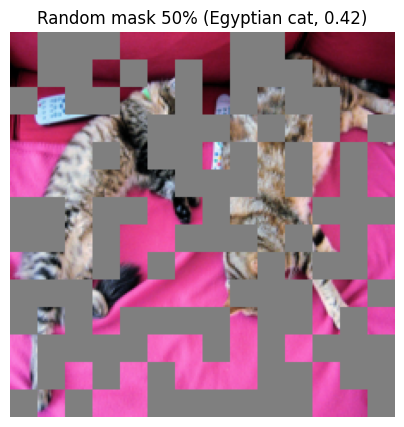


CENTER MASKING
block=4x4 (~8.2% patches)  pred=Egyptian cat               conf=0.9190


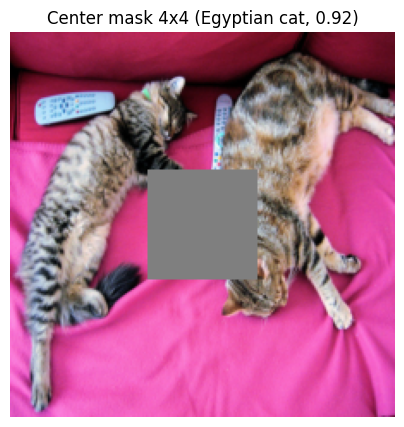

block=6x6 (~18.4% patches)  pred=Egyptian cat               conf=0.9519


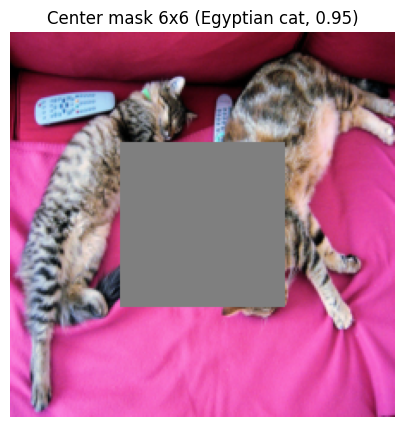

block=8x8 (~32.7% patches)  pred=Egyptian cat               conf=0.8363


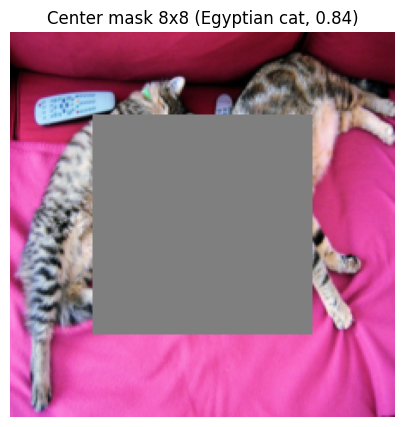

block=10x10 (~51.0% patches)  pred=Egyptian cat               conf=0.6510


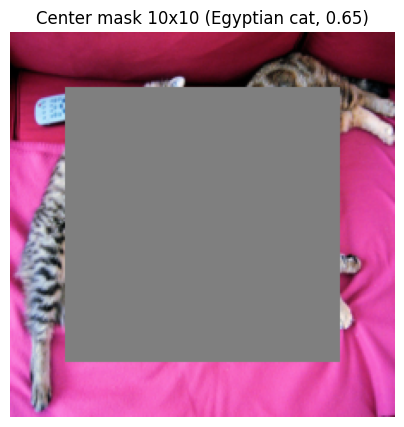

In [5]:
inputs = processor(images=img, return_tensors="pt").to(device)
pv0 = inputs["pixel_values"]

# baseline
base_id, base_label, base_conf, _ = predictFromPixelValues(pv0)
print(f"BASELINE: {base_label}  conf={base_conf:.4f}")
showMaskedImage(pv0, f"Baseline ({base_label}, {base_conf:.2f})")

# random masking
ratios = [0.1, 0.3, 0.5, 0.7]
trials = 5
for r in ratios:
    labels, confs = [], []
    for t in range(trials):
        pvMask = maskRandomPatches(pv0, r, fill=0.0)
        pid, plabel, pconf, _ = predictFromPixelValues(pvMask)
        labels.append(plabel)
        confs.append(pconf)

    mostCommon = max(set(labels), key=labels.count)
    avgConf = float(np.mean(confs))
    print(f"ratio={r:.1f}  most_common={mostCommon:25s}  avg_conf={avgConf:.4f}  labels={labels}")

pvMaskExample = maskRandomPatches(pv0, 0.5, fill=0.0)
pid, plabel, pconf, _ = predictFromPixelValues(pvMaskExample)
showMaskedImage(pvMaskExample, f"Random mask 50% ({plabel}, {pconf:.2f})")

# center masking of sizes 4x4, 6x6, 10x10
blocks = [4, 6, 8, 10]
print("\nCENTER MASKING")
for b in blocks:
    pvMask = maskCenterBlock(pv0, b, fill=0.0)
    pid, plabel, pconf, _ = predictFromPixelValues(pvMask)
    covered = (b*b)/NUM_PATCHES
    print(f"block={b}x{b} (~{covered:.1%} patches)  pred={plabel:25s}  conf={pconf:.4f}")

    showMaskedImage(pvMask, f"Center mask {b}x{b} ({plabel}, {pconf:.2f})")


### Part 5

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from transformers import AutoImageProcessor, ViTModel
device = "cuda" if torch.cuda.is_available() else "cpu"

train_ds = CIFAR10(root="./data", train=True, download=True, transform=None)
test_ds  = CIFAR10(root="./data", train=False, download=True, transform=None)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=2, collate_fn=collate_fn)
test_loader  = DataLoader(test_ds,  batch_size=128, shuffle=False, num_workers=2, collate_fn=collate_fn)


In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224")
backbone = ViTModel.from_pretrained("google/vit-base-patch16-224").to(device)

backbone.eval()
for p in backbone.parameters():
    p.requires_grad = False

HIDDEN = backbone.config.hidden_size  #768
NUM_CLASSES = 10
def collate_fn(batch):
    images = [x[0] for x in batch]
    labels = torch.tensor([x[1] for x in batch], dtype=torch.long)
    inputs = processor(images=images, return_tensors="pt")
    pixel_values = inputs["pixel_values"].to(device)
    labels = labels.to(device)

    return pixel_values, labels

@torch.no_grad()
def extractFeatures(pixel_values, pooling="cls"):
    out = backbone(pixel_values=pixel_values, return_dict=True)
    x = out.last_hidden_state
    if pooling == "cls":
        return x[:, 0, :]
    elif pooling == "mean":
        return x[:, 1:, :].mean(dim=1)

def evalProbe(probe, loader, pooling):
    probe.eval()
    correct = total = 0

    with torch.no_grad():
        for pixel_values, labels in loader:
            pixel_values = pixel_values.to(device)
            labels = labels.to(device)

            feats = extractFeatures(pixel_values, pooling=pooling)
            logits = probe(feats)
            pred = logits.argmax(dim=1)

            correct += (pred == labels).sum().item()
            total += labels.size(0)

    return correct / total

def trainLinearProbe(pooling, epochs=3, lr=1e-3):
    probe = nn.Linear(HIDDEN, NUM_CLASSES).to(device)
    opt = optim.AdamW(probe.parameters(), lr=lr)

    for ep in range(1, epochs + 1):
        probe.train()
        runningLoss = 0.0

        for pixel_values, labels in train_loader:
            pixel_values = pixel_values.to(device)
            labels = labels.to(device)

            feats = extractFeatures(pixel_values, pooling=pooling)
            logits = probe(feats)
            loss = F.cross_entropy(logits, labels)

            opt.zero_grad()
            loss.backward()
            opt.step()

            runningLoss += loss.item()

        val_acc = evalProbe(probe, test_loader, pooling)
        print(f"[{pooling}] epoch {ep}/{epochs}  loss={runningLoss/len(train_loader):.4f}  test_acc={val_acc:.4f}")

    return probe


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
probeCls  = trainLinearProbe("cls",  epochs=3, lr=1e-3)
probeMean = trainLinearProbe("mean", epochs=3, lr=1e-3)


[cls] epoch 1/3  loss=0.1439  test_acc=0.9667
[cls] epoch 2/3  loss=0.0838  test_acc=0.9670
[cls] epoch 3/3  loss=0.0718  test_acc=0.9679
[mean] epoch 1/3  loss=0.1500  test_acc=0.9698
[mean] epoch 2/3  loss=0.0798  test_acc=0.9710
[mean] epoch 3/3  loss=0.0677  test_acc=0.9709
